# Nearest Neighbors and K-Means

Tecnun - UNAV
Winter Course 2019 <p>
drosquete@ceit.es

When exploring a large set of documents -- such as Wikipedia, news articles, StackOverflow, etc. -- it can be useful to get a list of related material. To find relevant documents you typically
* Decide on a notion of similarity
* Find the documents that are most similar 

In the assignment you will
* Gain intuition for different notions of similarity and practice finding similar documents. 
* Explore the tradeoffs with representing documents using raw word counts and TF-IDF
* Explore the behavior of different distance metrics by looking at the Wikipedia pages most similar to President Obama’s page.

## Import necessary packages

As usual we need to first import the Python packages that we will need.

In [1]:
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer # It will be used to create a observation_word_count sparseMatrix
import numpy as np
import pandas as pd
import math
import string
import re # Regular Expressions library
from collections import Counter # High-performance container datatypes
np.random.seed(1234)

## Load Wikipedia dataset

We will be using dataset of Wikipedia pages. Each element of the dataset consists of a link to the wikipedia article, the name of the person, and the text of the article (in lowercase).  

In [2]:
wiki = pd.read_csv('people_wiki.csv')
wiki.shape

(59071, 3)

In [3]:
wiki.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


In [4]:
wiki['name'].sample(30)

14873                       Meseret Hailu
13373                Sandra J. Feuerstein
46667               Mary Davis (activist)
21898                         Helen Grime
33512    Kenneth Falconer (mathematician)
11242                         Lucy Panton
9656                    Harold Cartwright
49034                     Daniel Migliore
21619                        Johan Reuter
45815                      Roberto Merlin
46330                        Brett Domino
2891                       Akbar S. Ahmed
15056      Alexander George (philosopher)
36303                    Kate Gulbrandsen
56056                       Matthew Engel
34987                       Bruce Ashmore
36194           Peter Sykora (footballer)
42576                         Dick Biondi
40421                      George Hinshaw
17061                      Louise Plummer
32923                       Kyoko Hayashi
11214                       Yannis Pappas
45600                 Katsuhiko Ishibashi
44967                         John

## Extract word count vectors

As we have seen in previous lessons, we can work on word count 

In [5]:
# Use this token pattern to keep single-letter words
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
    
    # fit_transform, learns vocabulary from the training data and assign columns to words
    # Then convert the training data into a sparse matrix
train_matrix = vectorizer.fit_transform(wiki['text'])

    # Second, convert the test data into a sparse matrix, using the same word-column mapping.
    # if any word on the test is not present on the trained sparse_matrix, it will not
    # count it
test_matrix = vectorizer.transform(wiki['text'])

## Find nearest neighbors

Let's start by finding the nearest neighbors of the Barack Obama page using the word count vectors to represent the articles and Euclidean distance to measure distance.  

In [8]:
model = NearestNeighbors()
model.fit(train_matrix)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

Now let's look for Obama

In [9]:
wiki[wiki['name']=='Barack Obama'].index[0]

35817

Using his index, now, let's check the content

In [10]:
wiki.iloc[35817]

URI            <http://dbpedia.org/resource/Barack_Obama>
name                                         Barack Obama
text    barack hussein obama ii brk husen bm born augu...
Name: 35817, dtype: object

### Knowing neighbors

Take the train_matrix position of the person you want to measure

In [11]:
train_matrix[35817]

<1x548465 sparse matrix of type '<class 'numpy.int64'>'
	with 273 stored elements in Compressed Sparse Row format>

Create a model with it returning 10 neighbors and their distances

In [12]:
model.kneighbors(train_matrix[35817], 10, return_distance=True)

(array([[ 0.        , 33.07567082, 34.39476704, 36.15245497, 36.16628264,
         36.33180425, 36.40054945, 36.49657518, 36.63331817, 36.95943723]]),
 array([[35817, 24478, 28447, 35357, 14754, 13229, 31423, 22745, 36364,
          9210]], dtype=int64))

Since it is complicated to check each index, let's create a function that assembly all, names, indexes and distances

In [13]:
def getRelatedNames(name,ammount,modelo,matrix):
    if(len(wiki[wiki['name']==name])>0):
        index = wiki[wiki['name']==name].index[0]
        result = modelo.kneighbors(matrix[index], ammount, return_distance=True)
        DF = []
        for i in range(0,ammount):
            new = {'QueryName':name,
                         'Reference':wiki['name'].iloc[result[1][0][i]],
                         'Distance':result[0][0][i],
                         'Rank':i}
            DF.append(new)
        DF = pd.DataFrame(DF)
        return DF
    else:
        print("There are none with such name")

In [14]:
getRelatedNames('Barack Obama',10,model,train_matrix)

,Distance,QueryName,Rank,Reference
0,0.000000,Barack Obama,0,Barack Obama
1,33.075671,Barack Obama,1,Joe Biden
2,34.394767,Barack Obama,2,George W. Bush
3,36.152455,Barack Obama,3,Lawrence Summers
4,36.166283,Barack Obama,4,Mitt Romney
5,36.331804,Barack Obama,5,Francisco Barrio
6,36.400549,Barack Obama,6,Walter Mondale
7,36.496575,Barack Obama,7,Wynn Normington Hugh-Jones
8,36.633318,Barack Obama,8,Don Bonker
9,36.959437,Barack Obama,9,Andy Anstett


## Those are Obama's neighbors on wikipedia! Pretty cool right?

# From which words?
Now that I can relate them. I need to know why they are related, so, I have to check the words. These functions were used on the previous notebook

In [15]:
def count_words(s):
    # Pass all the words to lowercase and split them
    word_list = str(s).lower().split()
    #Use regular expressions to take only the alphanumeric words values
    words = re.findall(r'\w+', str(word_list))
    #Use Counter to get the word count
    return Counter(words)
def strip_punctuation(s):
    return ''.join([i for i in str(s) if i not in string.punctuation])

Let's clean the data

In [16]:
wikiWC = wiki
wikiWC['text_clean'] = wikiWC['text'].apply(strip_punctuation)
wikiWC['word_count'] = wikiWC['text_clean'].apply(count_words)

** So, which is the most common word?**

In [17]:
wikiWC['word_count'].iloc[35817].most_common(10)[0][0]

'the'

** Which are the top N words?**
Let's create a function for that

In [19]:
def top_words(name,ammount):
    if(len(wiki[wiki['name']==name])>0):
        index = wiki[wiki['name']==name].index[0]
        lista = wikiWC['word_count'].iloc[index].most_common(ammount)
        DF = []
        for i in range(0,ammount):
            new = {'Word':lista[i][0],
                         'Count':lista[i][1]}
            DF.append(new)
        DF = pd.DataFrame(DF)
        return DF
    else:
        print("There are none with such name")

In [20]:
obama_words = top_words('Barack Obama',20)
obama_words.head()

,Count,Word
0,40,the
1,30,in
2,21,and
3,18,of
4,14,to


In [21]:
barrio_words = top_words('Francisco Barrio',200)
barrio_words.head()

,Count,Word
0,36,the
1,24,of
2,18,and
3,17,in
4,10,he


Those words doesn't seem to be too significative...

** Can these lists merge to check similarities?** 

In [24]:
combined_words = obama_words.merge(barrio_words, on='Word',how='right').dropna()
combined_words.head(10)

,Count_x,Word,Count_y
0,40.0,the,36
1,30.0,in,17
2,21.0,and,18
3,18.0,of,24
4,14.0,to,9
5,11.0,his,5
6,7.0,a,6
7,7.0,he,10
8,6.0,as,5
9,5.0,was,4


In [25]:
combined_words = combined_words.rename(columns={'Count_x':'Obama', 'Count_y':'Barrio'})
combined_words[['Word','Obama','Barrio']]

,Word,Obama,Barrio
0,the,40.0,36
1,in,30.0,17
2,and,21.0,18
3,of,18.0,24
4,to,14.0,9
5,his,11.0,5
6,a,7.0,6
7,he,7.0,10
8,as,6.0,5
9,was,5.0,4


# TF-IDF to the rescue!

In [26]:
wiki[wiki['name']=='Barack Obama']['text']

35817    barack hussein obama ii brk husen bm born augu...
Name: text, dtype: object

Let's vectorize according to TF-IDF, and see if the words change, and the neighbors change?

In [27]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizertf = TfidfVectorizer()

train_matrixtf = vectorizertf.fit_transform(wiki['text'])

weightstf = vectorizertf.idf_

In [28]:
weightstf.shape

(548429,)

Let's print the most important words! (According to TF-IDF)

In [29]:
occ = np.asarray(train_matrixtf.sum(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': vectorizertf.get_feature_names(), 'weight': weightstf, 'occ':occ})
weights_df.sort_values(by='weight', ascending=False).head(10)

,term,weight,occ
548428,zzts,11.293365,0.095168
285575,krugerhe,11.293365,0.139918
285586,kruislaan,11.293365,0.088331
285585,kruiningen,11.293365,0.142612
285584,kruifmafter,11.293365,0.065340
285582,krugmans,11.293365,0.115201
285581,krugmanrudyard,11.293365,0.094319
483175,teamamick,11.293365,0.047888
285579,kruglikova,11.293365,0.103305
285578,krugersdorp,11.293365,0.150712


I don't get any of that!!! So how does "the" weights?

In [30]:
weights_df[weights_df['term']=='the'].weight.values[0]

1.0001015761229268

Let's create a function to obtain the TF-IDF top words of a person

In [31]:
def top_wordsTF_IDF(name):
    if(len(wiki[wiki['name']==name])>0):
        index = wiki[wiki['name']==name].index[0]
        unique_words = set(wiki['text'].iloc[index].split())
        DF = []
        for word in unique_words:
            if(len(weights_df[weights_df['term']==word].weight.values)>0):
                new = {'Weight':weights_df[weights_df['term']==word].weight.values[0],
                         'Word':word}
                DF.append(new)
        DF = pd.DataFrame(DF)
        return DF
    else:
        print("There are none with such name")

In [32]:
ObamaTopTF = top_wordsTF_IDF('Barack Obama')

In [33]:
ObamaTopTF.sort_values(by='Weight', ascending=False).head(10)

,Weight,Word
56,11.293365,2012obama
65,11.293365,laureateduring
97,11.293365,husen
37,10.887900,normalize
60,10.887900,brk
268,10.600218,doddfrank
252,9.907071,obamacare
205,9.789288,reauthorization
100,9.347455,reinvestment
216,8.654308,rodham


Those words.... Actually... They mean something, those are related to Obama!

Maybe it was a lucky guess! Let's try another guy. Nancy Sinatra!

In [34]:
NancyTopTF = top_wordsTF_IDF('Nancy Sinatra')

In [35]:
NancyTopTF.sort_values(by='Weight', ascending=False).head(10)

,Weight,Word
134,11.293365,walkinother
71,11.293365,conductorsinatra
57,11.293365,onenancy
15,11.293365,bighaired
72,10.600218,miniskirts
36,10.377074,goodnatured
121,10.194753,hazlewood
37,10.040602,singeractor
119,9.907071,somethin
111,9.789288,chers


# New Model

Now that the words have sense, let's create a new model with TF-IDF.

In [36]:
model = NearestNeighbors()
model.fit(train_matrixtf)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

Let's see Obama's new neighbors:

In [38]:
getRelatedNames('Barack Obama',10,model,train_matrixtf)

,Distance,QueryName,Rank,Reference
0,0.000000,Barack Obama,0,Barack Obama
1,1.068439,Barack Obama,1,Joe Biden
2,1.109896,Barack Obama,2,Hillary Rodham Clinton
3,1.118028,Barack Obama,3,Samantha Power
4,1.139969,Barack Obama,4,Eric Stern (politician)
5,1.147769,Barack Obama,5,George W. Bush
6,1.150374,Barack Obama,6,John McCain
7,1.154939,Barack Obama,7,Artur Davis
8,1.157761,Barack Obama,8,Henry Waxman
9,1.159678,Barack Obama,9,Jeff Sessions


Let's try with the euclidean distance:

In [39]:
model = NearestNeighbors(n_neighbors=10,metric='euclidean')
model.fit(train_matrixtf)
getRelatedNames('Barack Obama',10,model,train_matrixtf)

,Distance,QueryName,Rank,Reference
0,0.000000,Barack Obama,0,Barack Obama
1,1.068439,Barack Obama,1,Joe Biden
2,1.109896,Barack Obama,2,Hillary Rodham Clinton
3,1.118028,Barack Obama,3,Samantha Power
4,1.139969,Barack Obama,4,Eric Stern (politician)
5,1.147769,Barack Obama,5,George W. Bush
6,1.150374,Barack Obama,6,John McCain
7,1.154939,Barack Obama,7,Artur Davis
8,1.157761,Barack Obama,8,Henry Waxman
9,1.159678,Barack Obama,9,Jeff Sessions


How about a famous actor?

In [40]:
getRelatedNames('Al Pacino',10,model,train_matrixtf)

,Distance,QueryName,Rank,Reference
0,0.000000,Al Pacino,0,Al Pacino
1,1.150670,Al Pacino,1,Robert De Niro
2,1.151830,Al Pacino,2,Russell Crowe
3,1.185082,Al Pacino,3,Sean Penn
4,1.186615,Al Pacino,4,Meryl Streep
5,1.187954,Al Pacino,5,Ethan Hawke
6,1.189877,Al Pacino,6,Ralph Fiennes
7,1.190662,Al Pacino,7,George Clooney
8,1.192521,Al Pacino,8,Jack Nicholson
9,1.197527,Al Pacino,9,Daniel Day-Lewis


## What happened with the "bad" words?

In [41]:
occ = np.asarray(test_matrix.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'term': vectorizer.get_feature_names(), 'occurrences': occ})
counts_df.sort_values(by='occurrences', ascending=False).head(20)

,term,occurrences
488178,the,1156479
251924,in,668317
58917,and,641587
360093,of,631290
41705,a,406426
233792,he,310487
494571,to,301421
525878,was,233234
202478,for,223928
68190,as,182483


What happens if we wnat to calculate the distance between Obama and Al Pacino or any others?

In [42]:
def getDistancesNames(name1,name2,modelo,matrix):
    if(len(wiki[wiki['name']==name1])>0):
        index = wiki[wiki['name']==name1].index[0]
        result = modelo.kneighbors(matrix[index], len(wiki)-1, return_distance=True)
        DF = []
        for i in range(0,len(wiki)-1):
            if(wiki['name'].iloc[result[1][0][i]]==name2):
                new = {'QueryName':name1,
                             'Reference':wiki['name'].iloc[result[1][0][i]],
                             'Distance':result[0][0][i],
                             'Rank':i}
                DF.append(new)
        DF = pd.DataFrame(DF)
        return DF
    else:
        print("There are none with such name")

In [43]:
getDistancesNames('Barack Obama','Al Pacino',model,train_matrixtf)

,Distance,QueryName,Rank,Reference
0,1.316875,Barack Obama,26569,Al Pacino


# K-means
For this example, let's use a new dataset, that is lighter and more interesting for us.<p>
This data set compromises the metadata for the 2014 AAAI conference's accepted papers, including paper titles, authors, abstracts, and keywords of varying granularity. It's an UCI dataset.

In [44]:
papers = pd.read_csv('papers.csv')
papers.head()

,title,authors,groups,keywords,topics,abstract
0,Kernelized Bayesian Transfer Learning,Mehmet Gönen and Adam A. Margolin,Novel Machine Learning Algorithms (NMLA),cross-domain learning\ndomain adaptation\nkern...,APP: Biomedical / Bioinformatics\nNMLA: Bayesi...,Transfer learning considers related but distin...
1,"""Source Free"" Transfer Learning for Text Class...","Zhongqi Lu, Yin Zhu, Sinno Pan, Evan Xiang, Yu...",AI and the Web (AIW)\nNovel Machine Learning A...,Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,Transfer learning uses relevant auxiliary data...
2,A Generalization of Probabilistic Serial to Ra...,Haris Aziz and Paul Stursberg,Game Theory and Economic Paradigms (GTEP),social choice theory\nvoting\nfair division\ns...,GTEP: Game Theory\nGTEP: Social Choice / Voting,The probabilistic serial (PS) rule is one of t...
3,Lifetime Lexical Variation in Social Media,"Liao Lizi, Jing Jiang, Ying Ding, Heyan Huang ...",NLP and Text Mining (NLPTM),Generative model\nSocial Networks\nAge Prediction,AIW: Web personalization and user modeling\nNL...,As the rapid growth of online social media att...
4,Hybrid Singular Value Thresholding for Tensor ...,"Xiaoqin Zhang, Zhengyuan Zhou, Di Wang and Yi Ma",Knowledge Representation and Reasoning (KRR)\n...,tensor completion\nlow-rank recovery\nhybrid s...,KRR: Knowledge Representation (General/Other)\...,"In this paper, we study the low-rank tensor co..."


Keywords and topics columns shows "\n" as a regular character, so let's remove it with regular expresions:

In [45]:
papers['keywords'].replace('\n,?',' ',regex=True,inplace=True)

In [46]:
papers['topics'].replace('\n,?',' ',regex=True,inplace=True)

In [47]:
papers['topics'].sample(n=5)

146                                HSO: Heuristic Search
381    CS: Natural language understanding and dialogu...
193                    NMLA: Supervised Learning (Other)
134    GTEP: Auctions and Market-Based Systems GTEP: ...
166    GTEP: Game Theory GTEP: Coordination and Colla...
Name: topics, dtype: object

Since TF-IDF was better, let's use it again.

In [48]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizertf = TfidfVectorizer()

train_matrixtf = vectorizertf.fit_transform(papers['keywords'])

weightstf = vectorizertf.idf_

### It's ML time!
Let's invoke k-means, fit and test:

In [50]:
from sklearn.cluster import KMeans
from time import time
KClusters = 5
km = KMeans(n_clusters=KClusters, init='k-means++')
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(train_matrixtf)
print("done in %0.3fs" % (time() - t0))

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)
done in 0.912s


Let's see the label's names

In [51]:
km.labels_

array([1, 1, 2, 2, 0, 4, 1, 0, 0, 1, 0, 3, 4, 2, 0, 0, 0, 3, 1, 1, 0, 2,
       0, 4, 1, 0, 0, 4, 2, 2, 2, 3, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 4,
       2, 0, 1, 1, 0, 3, 0, 0, 0, 0, 1, 4, 2, 0, 0, 0, 2, 0, 0, 1, 2, 0,
       0, 2, 0, 0, 2, 0, 1, 0, 0, 4, 0, 0, 0, 2, 0, 0, 2, 4, 0, 0, 1, 3,
       1, 0, 1, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 3, 1, 3,
       2, 4, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 1, 3, 3, 1, 4, 3, 1, 3, 0, 0,
       1, 0, 0, 0, 0, 0, 3, 0, 0, 4, 0, 1, 1, 0, 3, 0, 3, 0, 0, 0, 3, 0,
       1, 0, 2, 3, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 3, 0, 3, 0, 3, 0, 0, 1,
       0, 4, 2, 3, 0, 3, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 4, 1, 1, 0, 3, 0,
       0, 1, 3, 0, 0, 0, 0, 0, 3, 4, 0, 0, 1, 1, 3, 0, 4, 1, 3, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 3, 0, 1, 0, 2, 0, 0, 4, 0, 0, 0, 0,
       0, 1, 2, 0, 1, 4, 4, 0, 0, 0, 0, 0, 1, 2, 4, 0, 0, 1, 1, 2, 2, 0,
       1, 0, 3, 4, 2, 0, 2, 4, 2, 4, 0, 0, 4, 0, 0, 4, 0, 3, 0, 0, 0, 0,
       3, 0, 1, 0, 0, 3, 0, 1, 0, 2, 0, 0, 1, 1, 0,

WTF!? What are those numbers? I don't get it!
Let's transform that in something I can read

In [52]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizertf.get_feature_names()
for i in range(KClusters):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:
 game
 games
 theory
 data
 search
 reasoning
 analysis
 knowledge
 graph
 language
Cluster 1:
 learning
 multi
 supervised
 machine
 reinforcement
 classification
 transfer
 feature
 online
 semi
Cluster 2:
 social
 choice
 computational
 networks
 fair
 division
 network
 algorithms
 of
 prediction
Cluster 3:
 planning
 based
 probabilistic
 systems
 and
 model
 uncertainty
 reasoning
 search
 inference
Cluster 4:
 optimization
 constraint
 embedding
 scheduling
 satisfiability
 reduction
 search
 maximum
 dimensionality
 image


**What if I want to plot it?**
It's not as easy as you may think. It requires a principal component analysis

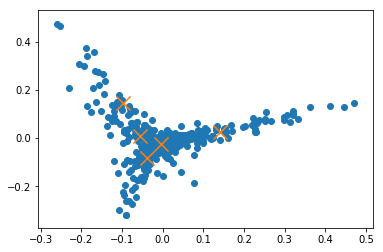

In [53]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline

pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('tfidf', TfidfTransformer()),
])        
X = pipeline.fit_transform(papers['keywords']).todense()

pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
kmeans = KMeans(n_clusters=KClusters).fit(X)
centers2D = pca.transform(kmeans.cluster_centers_)

plt.scatter(data2D[:,0], data2D[:,1])
plt.scatter(centers2D[:,0], centers2D[:,1], 
            marker='x', s=200, linewidths=3)

How could it look like on theory?

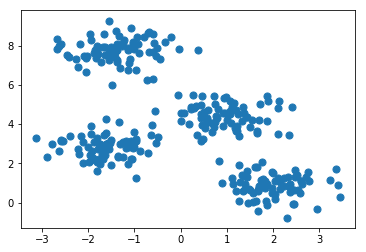

In [68]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

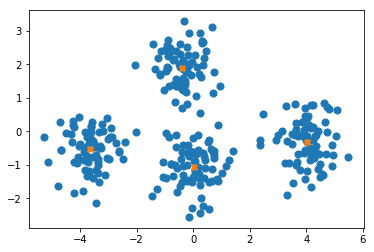

In [81]:
km = KMeans(n_clusters = 4).fit(X)
pca = PCA(n_components = 2).fit(X)
center = pca.transform(km.cluster_centers_)
data = pca.transform(X)
plt.scatter(data[:, 0], data[:, 1], s=50)
plt.scatter(center[:, 0], center[:, 1], marker = 'X', linewidths = 1)

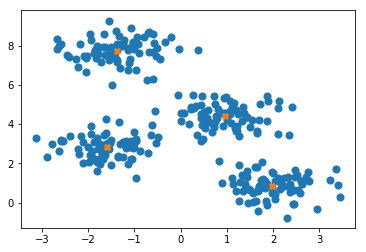

In [82]:
km = KMeans(n_clusters = 4).fit(X)
center = km.cluster_centers_
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.scatter(center[:, 0], center[:, 1], marker = 'X', linewidths = 1)